In [4]:
import numpy as np
import os
from os.path import join
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
data = np.load('megmag_data.npy')

In [6]:
num_repitions, num_sensors, num_time_samples = data.shape
times= np.arange(-200,804,4)

In [7]:
def covar_matrix(data):
     N = data.shape[0]
     for i in range(N):
          X = data[i]
          multiplication = np.dot(X, X.T)
          if i != 0: 
            sum = sum + multiplication
          else: 
            sum = multiplication
     corvar_mat = sum / N
     return(corvar_mat)

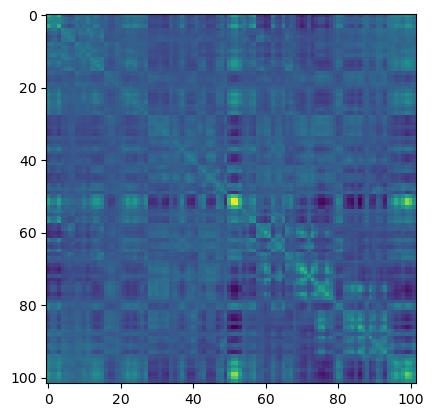

In [238]:
corvar_m = covar_matrix(data)
plt.imshow(corvar_m)

In [8]:
avg_over_rep = np.mean(data, axis = 0)
avg_over_rep.shape

(102, 251)

Exercise B1 (Emma)

In [9]:
y = np.load('pas_vector.npy')

In [10]:
#B1i
pas_1_2_indices = np.where((y == 1) | (y == 2))
y_1_2 = y[pas_1_2_indices[0]]
data_1_2 = data[pas_1_2_indices[0]]
#Bii
X_1_2 = np.reshape(data_1_2, (data_1_2.shape[0],(num_sensors*num_time_samples)))

In [180]:
#B1iii
scaling = StandardScaler()
X_1_2_z = scaling.fit_transform(X_1_2)

In [15]:
#B1iv 
def logistic_regression(X_train, X_test, y_train, y_test, solver, penalty): 
    clf = LogisticRegression(penalty = penalty, solver = solver, random_state = 1)
    clf.fit(X_train, y_train)
    scoring = clf.score(X_test,y_test)
    coef = clf.coef_[0]
    track_nonzero_coef = np.sum(coef != 0)
    return(coef, scoring, track_nonzero_coef)

In [11]:
#B1iv
X_1_2_train, X_1_2_test, y_1_2_train, y_1_2_test = train_test_split(X_1_2, y_1_2, test_size = 0.3, random_state = 1)
scaling = StandardScaler()
X_1_2_train_z =  scaling.fit_transform(X_1_2_train)
X_1_2_test_z = scaling.transform(X_1_2_test)

In [24]:
#B1v
coef_none,acc_none, track_nonzero_coef_none = logistic_regression(X_1_2_train_z, X_1_2_test_z, y_1_2_train, y_1_2_test, penalty = None, solver = 'saga')
coef_l1,acc_l1, track_nonzero_coef_l1 = logistic_regression(X_1_2_train_z, X_1_2_test_z, y_1_2_train, y_1_2_test, penalty = 'l1', solver = 'liblinear')

/Users/emma/miniconda3-new/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
print('Accuracy of the classifier without using any penalty: ', acc_none)
print('Number of non-zero coefficients of the classifier without using any penalty: ', track_nonzero_coef_none)
print('Accuracy of the classifier with using l1 penalty: ', acc_l1)
print('Number of non-zero coefficients of the classifier with using l1 penalty: ', track_nonzero_coef_l1)

We are definitely overfitting, not only can we tell by the accuracy but also from the fact that each of the sensors has a coefficient (no 0 coefficients). 

In [222]:
#B1vii
def covar_matrix2(coef):
    covar = coef @ coef.T
    return(covar)

In [ ]:
#B1vii
coef_nonzero_l1 = np.where(coef_l1 != 0)
X_1_2_reduced = np.array(X_1_2[:,coef_nonzero_l1[0]])
plt.imshow(covar_matrix2(X_1_2_reduced))

There is less covariance within the reduced feature vector matrix than in the non-reduced one. 

In [77]:
#B2ii
def equalize_targets_binary(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 2:
        raise NameError("can't have more than two targets")
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

In [108]:
#B2ii
data_1_2_eq, y_1_2_eq = equalize_targets_binary(data_1_2, y_1_2)

(214, 102, 251)

In [109]:
#B2ii
X_1_2_eq = np.reshape(data_1_2_eq, (data_1_2_eq.shape[0],(num_sensors*num_time_samples)))
X_1_2_eq_z = scaling.transform(X_1_2_eq)

In [241]:
#B2iv
def cross_val_classifiers(X, y, C): 
    clf = LogisticRegression(penalty = 'l2', solver = 'liblinear', random_state=1, C = C)
    clf.fit(X,y)
    scoring_cross_val_mn = np.mean(cross_val_score(clf, X, y , cv=5))
    print('Mean accuracy of classifier with C = ', C , ':',np.mean(scoring_cross_val_mn))

In [242]:
#B2iii, iv
cross_val_classifiers(X_1_2_eq_z, y_1_2_eq, C = 1e5)
cross_val_classifiers(X_1_2_eq_z, y_1_2_eq, C = 1e1)
cross_val_classifiers(X_1_2_eq_z, y_1_2_eq, C = 1e-5)

Mean accuracy of classifier with C = 1e5  0.525128205128205


On average approx 6% more of the samples are predicted correctly than in the other ones. That equals to about 11 more correct predictions. 

In [256]:
#B2v
X_1_2_timestamps = data_1_2.reshape(data_1_2.shape[0]*data_1_2.shape[1])
X_reshaped = data_1_2.reshape(-1, data_1_2.shape[2])
X_reshaped_z = scaling.fit_transform(X_reshaped)
X_1_2_timestamps_z = X_reshaped_z.reshape(data_1_2.shape)

In [158]:
#B2v
def fit_each_timesample(data, y, penalty, C): 
    avg_acc = list()
    reps = data.shape[0]
    sensors = data.shape[1]
    time_samples = data.shape[2]
    clf = LogisticRegression(penalty = penalty, solver = 'liblinear', random_state=1, C = C)
    for i in range(time_samples): 
        X = np.empty((0, data.shape[1]))
        for j in range(reps):
            new_row = data[j,:, i]
            X = np.vstack([X, new_row])
        scoring_cross_val = cross_val_score(clf, X, y, cv=5)
        mean_acc = np.mean(scoring_cross_val)
        avg_acc.append(mean_acc)
    return(avg_acc)


In [ ]:
#B2v
accuracies_l1 = fit_each_timesample(X_1_2_timestamps_z, y_1_2, penalty = 'l1', C = 1e-1)
accuracies_l2 = fit_each_timesample(X_1_2_timestamps_z, y_1_2, penalty = 'l2', C = 1e-5)

In [287]:
print(np.where(accuracies_l1 == np.max(accuracies_l1))[0])
print('Peak performance was at time',time_steps[np.where(accuracies_l1 == np.max(accuracies_l1))[0]][0], 'ms.')

[110]
Peak performance was at time 240 ms.


In [258]:
#B2v
def plot_accuracy_timestamps(time_steps, accuracies, penalty_desc): 
    plt.figure(figsize=(8, 6))
    plt.plot(time_steps, accuracies, color="#E0B0FF", linestyle="-", linewidth=2)
    plt.axhline(y=0.5, color="black", linestyle="--", linewidth=1)
    plt.scatter(time_steps, accuracies, color="#E0B0FF", marker="o", s=30)
    plt.title("Average accuracies at different timestamps " + penalty_desc)
    plt.xlabel("Timestamps (ms)")
    plt.ylabel("Average accuracy")
    plt.show()


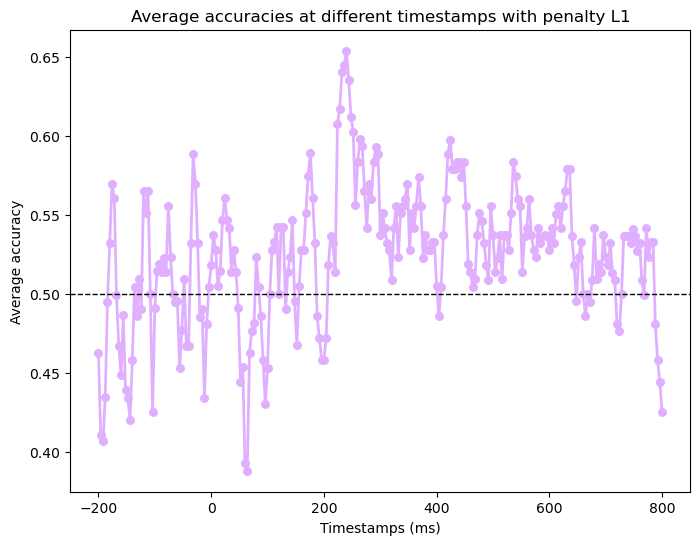

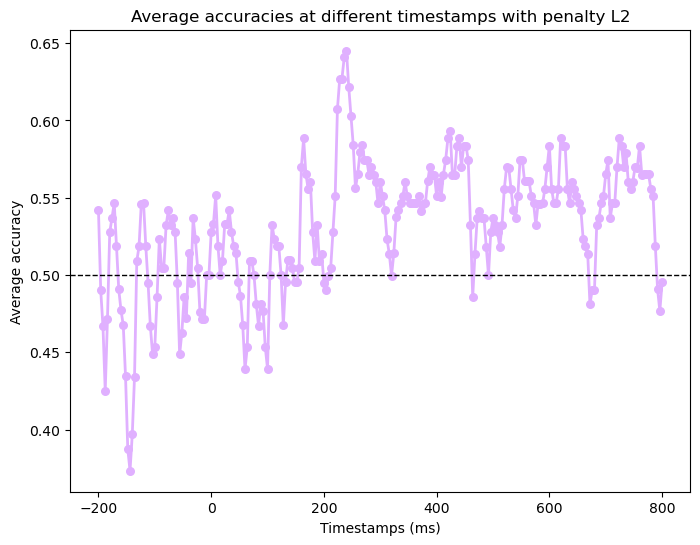

In [259]:
#B2v, vi
plot_accuracy_timestamps(times, accuracies_l1, penalty_desc = 'with penalty L1')
plot_accuracy_timestamps(times, accuracies_l2, penalty_desc = 'with penalty L2')

The performance peaks at around the sensor inputs from 240 ms after onset when using penalty L1. The performance peaks at around the same time when using penalty L2. 

In [262]:
#B2vii
pas_1_4_indices = np.where((y == 1) | (y == 4))
y_1_4 = y[pas_1_4_indices[0]]
data_1_4 = data[pas_1_4_indices[0]]
X_1_4 = np.reshape(data_1_4, (data_1_4.shape[0],(num_sensors*num_time_samples)))

X_reshaped2 = data_1_4.reshape(-1, data_1_4.shape[2])
X_reshaped2_z = scaling.fit_transform(X_reshaped2)
X_1_4_timestamps_z = X_reshaped2_z.reshape(data_1_4.shape)

In [264]:
#B2vii
accuracies_l2_1_4 = fit_each_timesample(X_1_4_timestamps_z, y_1_4, penalty = 'l2', C = 1e-5)

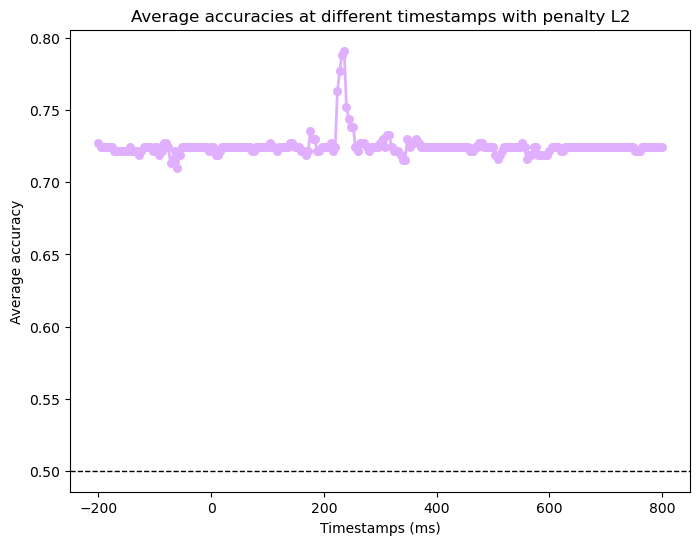

In [265]:
#B2vii
plot_accuracy_timestamps(times, accuracies_l1, penalty_desc = 'with penalty L2')


Pairwise classification is possible when the foundation is based on  sensor signals from specific timesteps. The performance peaks at around the sensor inputs from 240 ms after onset. The performance for classifying between PAS 1 and 4 is always over 0.7 accuracy vs when classifying between PAS 1 and 2 it is never over 0.7 accuracy. 